In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session




/kaggle/input/cat-and-dog-classifier/data/dog_test2.jpg
/kaggle/input/cat-and-dog-classifier/data/cat_test.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images133.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images412.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images141.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images356.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images77.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images210.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images525.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images272.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images68.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images360.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images69.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images396.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images239.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images494.jpg
/kaggle/input/cat-and-dog-classifier/data/Dog/images

In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
import imghdr

%matplotlib inline

In [3]:
data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/cat-and-dog-classifier/data')

Found 1152 files belonging to 2 classes.


In [4]:
data_iterator = data.as_numpy_iterator()

In [5]:
batch = data_iterator.next()

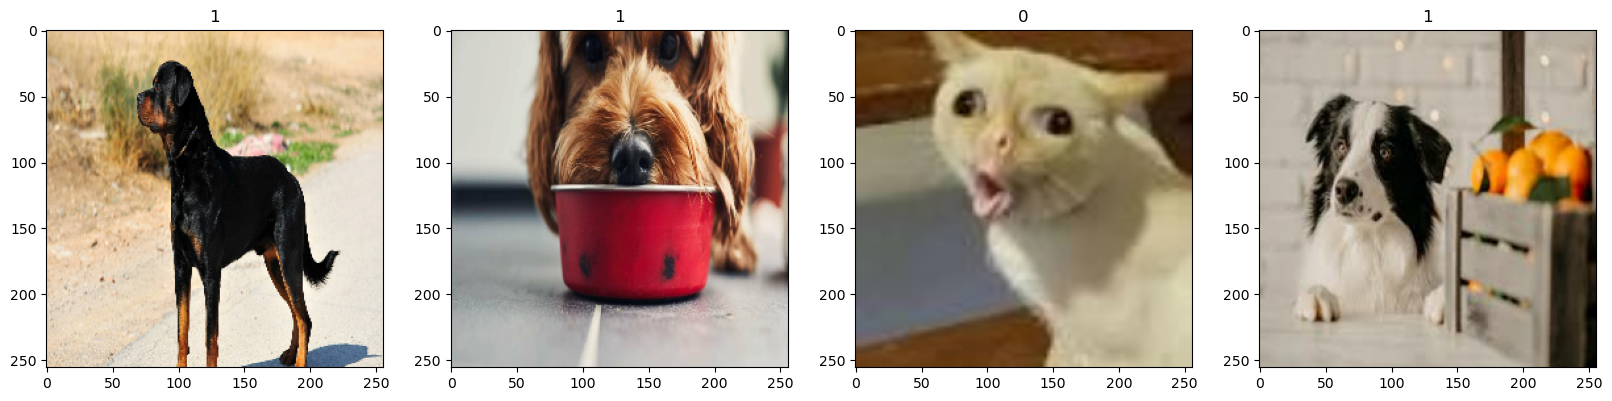

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [7]:
data = data.map(lambda x,y: (x/255, y))

In [8]:
data.as_numpy_iterator().next()

(array([[[[6.25256598e-01, 6.40942872e-01, 6.37021303e-01],
          [6.11607671e-01, 6.27293944e-01, 6.23372376e-01],
          [6.12174451e-01, 6.27860725e-01, 6.23939157e-01],
          ...,
          [6.92252576e-01, 7.07938850e-01, 7.04017282e-01],
          [7.18658090e-01, 7.34344363e-01, 7.30422795e-01],
          [7.33792901e-01, 7.49479175e-01, 7.45557606e-01]],
 
         [[6.55369163e-01, 6.71055436e-01, 6.67133868e-01],
          [6.61243856e-01, 6.76930130e-01, 6.73008561e-01],
          [6.41785383e-01, 6.57471657e-01, 6.53550088e-01],
          ...,
          [6.79699004e-01, 6.95385277e-01, 6.91463709e-01],
          [7.29013503e-01, 7.44699776e-01, 7.40778208e-01],
          [7.38392293e-01, 7.54078567e-01, 7.50156999e-01]],
 
         [[5.85267305e-01, 6.00953579e-01, 5.97032011e-01],
          [6.85232818e-01, 7.00919092e-01, 6.96997523e-01],
          [6.99885130e-01, 7.15571404e-01, 7.11649835e-01],
          ...,
          [6.76972270e-01, 6.92658544e-01, 6.8873

In [9]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [10]:
train_size

25

In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [13]:
model = Sequential()

In [14]:
model.add(Conv2D(16, (3,3), 1, activation='relu', padding = 'same', input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
model.add(Conv2D(32, (3,3), 1, activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
model.add(Conv2D(16, (3,3), 1, activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
#model.add(Conv2D(64, (3,3), 1, activation='relu', padding = 'same'))
#model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
#model.add(Conv2D(32, (3,3), 1, activation='relu', padding = 'same'))
#model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
#model.add(Conv2D(16, (3,3), 1, activation='relu', padding = 'same'))
#model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
#model.add(Conv2D(128, (3,3), 1, activation='relu', padding = 'same'))
#model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
#model.add(Conv2D(256, (3,3), 1, activation='relu', padding = 'same'))
#model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
#model.add(Conv2D(512, (3,3), 1, activation='relu', padding = 'same'))
#model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 16)       0

In [17]:
logdir='logs'

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [19]:
hist = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback])
print(hist.history)

best_score = max(hist.history['val_accuracy'])

print(f"Best Validation score is: {best_score}")

Epoch 1/50
25/25 [==============================] - 44s 2s/step - loss: 0.7737 - accuracy: 0.4875 - val_loss: 0.6910 - val_accuracy: 0.5312
Epoch 2/50
25/25 [==============================] - 42s 2s/step - loss: 0.6887 - accuracy: 0.5788 - val_loss: 0.6821 - val_accuracy: 0.6384
Epoch 3/50
25/25 [==============================] - 43s 2s/step - loss: 0.6541 - accuracy: 0.6263 - val_loss: 0.7481 - val_accuracy: 0.5134
Epoch 4/50
25/25 [==============================] - 40s 2s/step - loss: 0.6538 - accuracy: 0.6300 - val_loss: 0.5817 - val_accuracy: 0.7054
Epoch 5/50
25/25 [==============================] - 43s 2s/step - loss: 0.5729 - accuracy: 0.7025 - val_loss: 0.5859 - val_accuracy: 0.6786
Epoch 6/50
25/25 [==============================] - 43s 2s/step - loss: 0.4605 - accuracy: 0.7800 - val_loss: 0.4762 - val_accuracy: 0.7634
Epoch 7/50
25/25 [==============================] - 42s 2s/step - loss: 0.3624 - accuracy: 0.8487 - val_loss: 0.5075 - val_accuracy: 0.7857
Epoch 8/50
25/25 [==

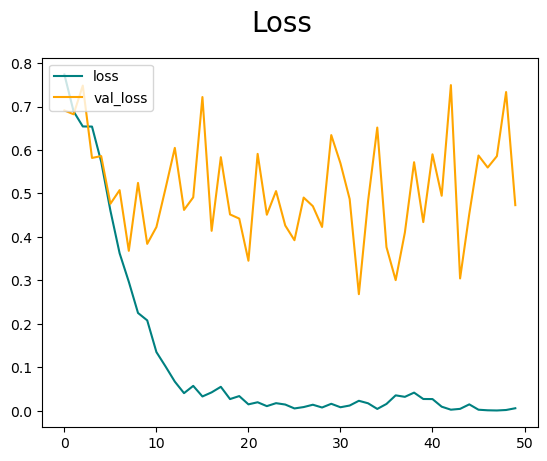

In [20]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

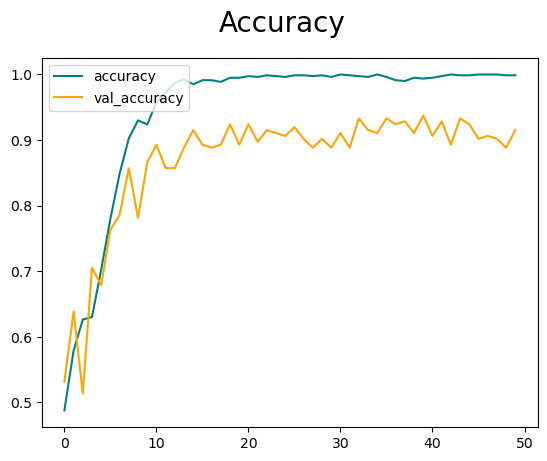

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [22]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [23]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [24]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 364ms/step


In [25]:
print(f"Precision: {pre.result().numpy()} , Recall: {re.result().numpy()}, BinaryAccuracy: {acc.result().numpy()}")

Precision: 0.8936170339584351 , Recall: 0.9333333373069763, BinaryAccuracy: 0.9166666865348816


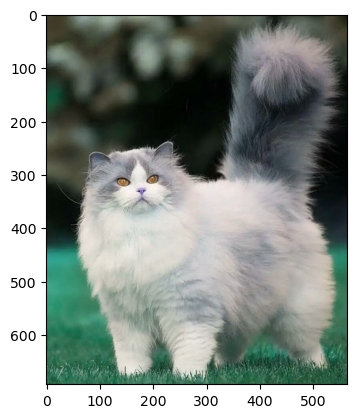

In [26]:
img = cv2.imread('/kaggle/input/cat-and-dog-classifier/data/cat_test.jpg')
plt.imshow(img)
plt.show()

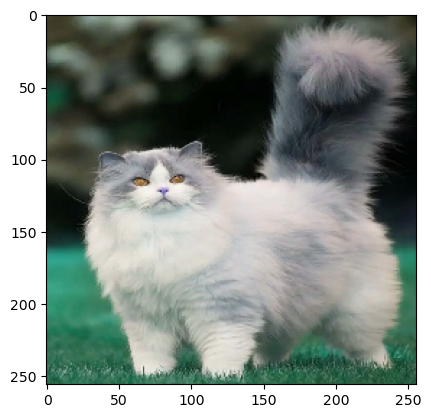

In [27]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [28]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 94ms/step


In [29]:
yhat

array([[0.02782974]], dtype=float32)

In [30]:
if yhat > 0.5: 
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')

Predicted class is Cat
